In [1]:
from skimage import feature, io, color, util, segmentation, transform, draw, img_as_ubyte, img_as_float, measure, img_as_bool, filters
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.cluster import KMeans
from scipy import optimize
from skimage.morphology import disk, dilation, erosion, square, closing
from scipy import ndimage as ndi
from skimage.future import graph

import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from skimage.draw import ellipse
from skimage.measure import label, regionprops, regionprops_table
from skimage.transform import rotate
from skimage.restoration import denoise_bilateral, estimate_sigma
from skimage import segmentation, exposure, morphology

from pillclassification.functions import image_equalization

utils/Dataset/merge/LFFY672LERB26SL7SA!8KV9HIC0HE0.JPG


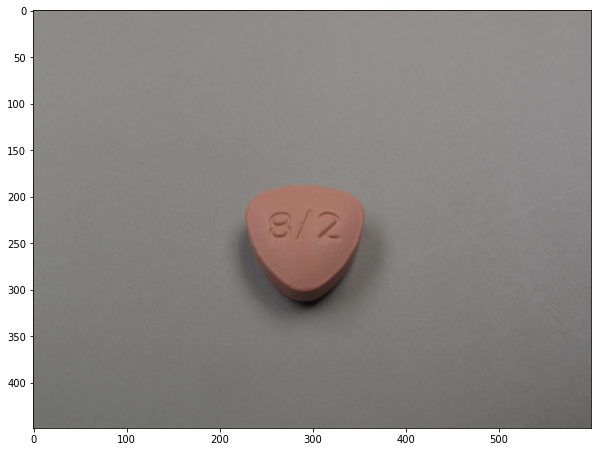

In [3]:
# Load image

images_dir = Path('utils/Dataset/merge')
filenames = [x for x in images_dir.iterdir() if x.suffix != '.xml']
# 0 33 263 274 283
filename = filenames[274]
print(filename)

# Crop / resize

image_orig = io.imread(filename)

if image_orig.shape[-1] == 4:
    image_orig = image_orig[:,:,:3]
    
crop_scale = 0.65
    
def crop_center(img):
    y,x,d = img.shape
    cropx = int(x * crop_scale)
    cropy = int(y * crop_scale)
    startx = int(x/2-(cropx/2))
    starty = int(y/2-(cropy/2)) - 100 
    return img[starty:starty+cropy,startx:startx+cropx,:]
    
height = 600
image = crop_center(image_orig)
image = transform.resize(image, (int(image.shape[0] * (height / image.shape[1])), height), anti_aliasing=True)
image = util.img_as_float(image)
plt.figure(figsize=(10,10))
plt.imshow(image)

# for i, f in enumerate(filenames):
#     print(i, ':', f)

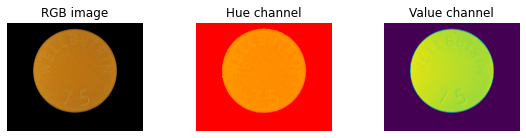

In [321]:
hsv_img = color.rgb2hsv(image)
hue_img = hsv_img[:, :, 0]
value_img = hsv_img[:, :, 2]

fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(8, 2))

ax0.imshow(image)
ax0.set_title("RGB image")
ax0.axis('off')
ax1.imshow(hue_img, cmap='hsv')
ax1.set_title("Hue channel")
ax1.axis('off')
ax2.imshow(value_img)
ax2.set_title("Value channel")
ax2.axis('off')

fig.tight_layout()

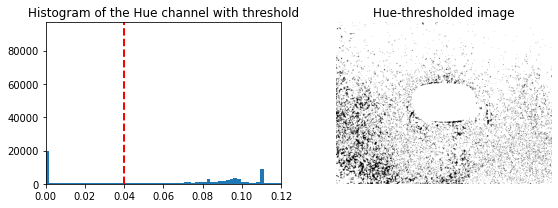

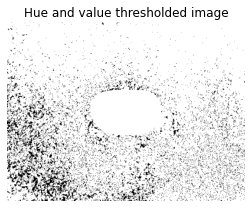

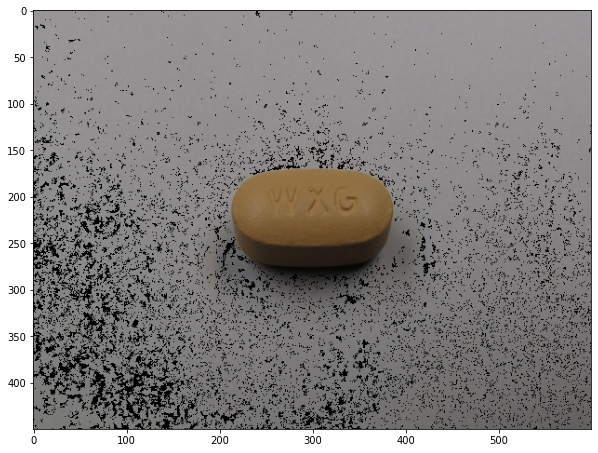

In [306]:
hue_threshold = 0.04
binary_img = hue_img > hue_threshold

fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(8, 3))

ax0.hist(hue_img.ravel(), 512)
ax0.set_title("Histogram of the Hue channel with threshold")
ax0.axvline(x=hue_threshold, color='r', linestyle='dashed', linewidth=2)
ax0.set_xbound(0, 0.12)
ax1.imshow(binary_img, cmap='gray')
ax1.set_title("Hue-thresholded image")
ax1.axis('off')

fig.tight_layout()

fig, ax0 = plt.subplots(figsize=(4, 3))

value_threshold = 0.10
binary_img = (hue_img > hue_threshold) | (value_img < value_threshold)

ax0.imshow(binary_img, cmap='gray')
ax0.set_title("Hue and value thresholded image")
ax0.axis('off')

fig.tight_layout()
plt.show()

fig, ax1 = plt.subplots(figsize=(10,10))

for i in range(3):
    image[:,:,i] = image[:,:,i] * binary_img

ax1.imshow(image)

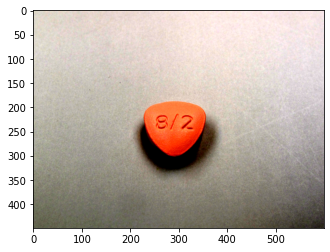

In [4]:
# img_eq = exposure.equalize_adapthist(image, clip_limit=0.01)

image_eq = image_equalization(image)
plt.imshow(image_eq)

In [ ]:
# SLIC

img = util.img_as_float(image)
img_slic = segmentation.slic(img, n_segments=300, compactness=25, sigma=5, start_label=1)

plt.figure(figsize=(10,10))

plt.imshow(segmentation.mark_boundaries(img, img_slic))

regions = regionprops(img_slic)
label_rgb = color.label2rgb(img_slic, img, kind='avg', bg_label=0)

plt.figure(figsize=(10,10))

plt.imshow(label_rgb)

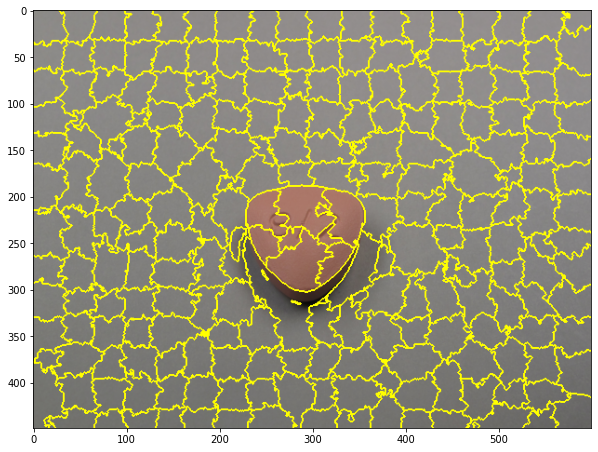

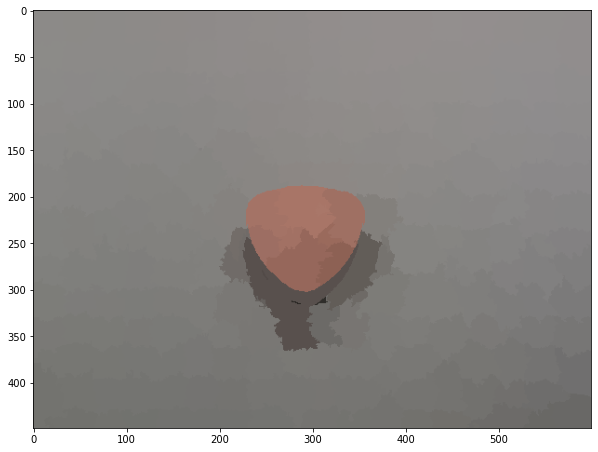

In [170]:
# WATERSHED

gradient = filters.sobel(color.rgb2gray(image))
img_slic = segmentation.watershed(gradient, markers=250, compactness=0.0001)

plt.figure(figsize=(10,10))
plt.imshow(segmentation.mark_boundaries(image, img_slic))

label_rgb = color.label2rgb(img_slic, image, kind='avg', bg_label=0)

plt.figure(figsize=(10,10))

plt.imshow(label_rgb)

449 600 3
Fitting model on a small sub-sample of the data
Predicting color indices on the full image (k-means)


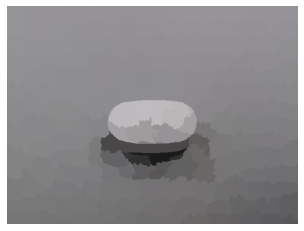

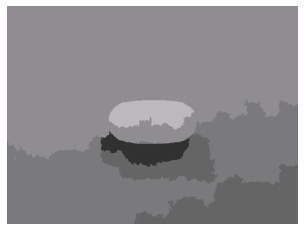

In [105]:
from sklearn.metrics import pairwise_distances_argmin
from sklearn.utils import shuffle

n_colors = 5

# Load Image and transform to a 2D numpy array.
w, h, d = label_rgb.shape
print(w,h,d)
assert d == 3

image_array = np.reshape(label_rgb, (w * h, d))


print("Fitting model on a small sub-sample of the data")
image_array_sample = shuffle(image_array, random_state=0)[:1000]
kmeans = KMeans(n_clusters=n_colors, random_state=0).fit(image_array_sample)

# Get labels for all points
print("Predicting color indices on the full image (k-means)")
labels = kmeans.predict(image_array)

# codebook_random = shuffle(image_array, random_state=0)[:n_colors]
# print("Predicting color indices on the full image (random)")

# labels_random = pairwise_distances_argmin(codebook_random,
#                                          image_array,
#                                          axis=0)

def recreate_image(codebook, labels, w, h):
    """Recreate the (compressed) image from the code book & labels"""
    d = codebook.shape[1]
    image = np.zeros((w, h, d))
    label_idx = 0
    for i in range(w):
        for j in range(h):
            image[i][j] = codebook[labels[label_idx]]
            label_idx += 1
    return image

# Display all results, alongside original image
plt.figure(1)
plt.clf()
plt.axis('off')
plt.imshow(label_rgb)

plt.figure(2)
plt.clf()
plt.axis('off')
image_knn = recreate_image(kmeans.cluster_centers_, labels, w, h)
plt.imshow(recreate_image(kmeans.cluster_centers_, labels, w, h))

# plt.figure(3)
# plt.clf()
# plt.axis('off')
# plt.title('Quantized image (64 colors, Random)')
# plt.imshow(recreate_image(codebook_random, labels_random, w, h))
# plt.show()

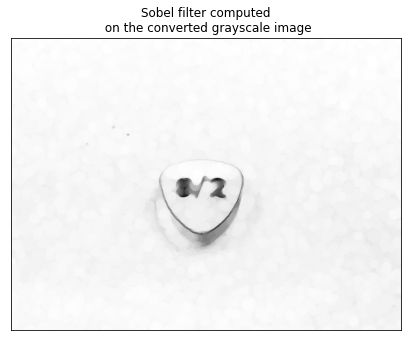

In [190]:
def as_gray(image_filter, image, *args, **kwargs):
    gray_image = color.rgb2gray(image)
    return image_filter(gray_image, *args, **kwargs)

from skimage.color.adapt_rgb import adapt_rgb, each_channel

@adapt_rgb(as_gray)
def sobel_gray(image):
    return filters.sobel(image)

@adapt_rgb(each_channel)
def sobel_each(image):
    return filters.sobel(image)


fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(7, 7))

edges = sobel_gray(image)
# edges = morphology.black_tophat(edges, morphology.disk(6))
edges = morphology.closing(edges, morphology.disk(6))
# edges = morphology.dilation(edges, morphology.disk(6))

# We use 1 - sobel_gray(image) but this won't work if image is not normalized
ax.imshow(exposure.rescale_intensity(1 - edges), cmap=plt.cm.gray)
ax.set_xticks([]), ax.set_yticks([])
ax.set_title("Sobel filter computed\n on the converted grayscale image")

plt.show()

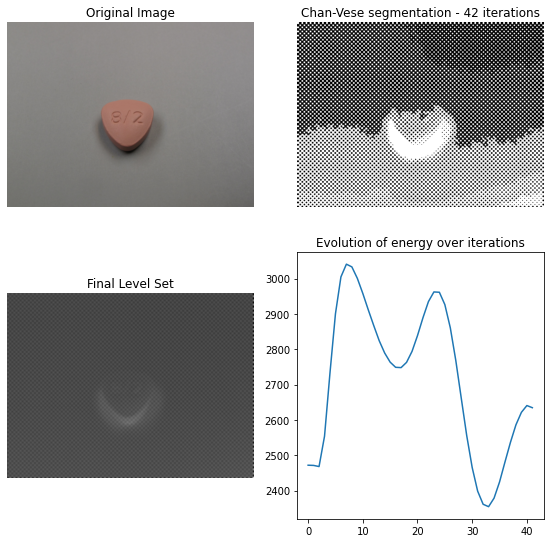

In [199]:
cv = segmentation.chan_vese(color.rgb2gray(image), mu=1.5, lambda1=1, lambda2=1, tol=1e-3, max_iter=300,
               dt=0.5, init_level_set="checkerboard", extended_output=True)

fig, axes = plt.subplots(2, 2, figsize=(8, 8))
ax = axes.flatten()

ax[0].imshow(image, cmap="gray")
ax[0].set_axis_off()
ax[0].set_title("Original Image", fontsize=12)

ax[1].imshow(cv[0], cmap="gray")
ax[1].set_axis_off()
title = "Chan-Vese segmentation - {} iterations".format(len(cv[2]))
ax[1].set_title(title, fontsize=12)

ax[2].imshow(cv[1], cmap="gray")
ax[2].set_axis_off()
ax[2].set_title("Final Level Set", fontsize=12)

ax[3].plot(cv[2])
ax[3].set_title("Evolution of energy over iterations", fontsize=12)

fig.tight_layout()
plt.show()

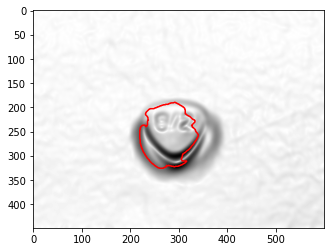

In [211]:
# Morphological GAC
gimage = segmentation.inverse_gaussian_gradient(color.rgb2gray(image))

# Initial level set
init_ls = np.zeros(color.rgb2gray(image).shape, dtype=np.int8)
init_ls[10:-10, 10:-10] = 1

ls = segmentation.morphological_geodesic_active_contour(gimage, 250, init_ls,
                                           smoothing=1, balloon=-1,
                                           threshold=0.8)

plt.figure()
plt.imshow(gimage, cmap="gray")
plt.contour(ls, [0.5], colors='r')

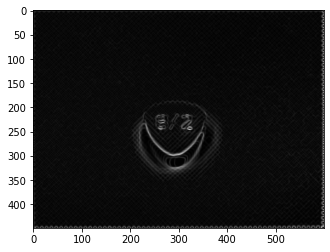

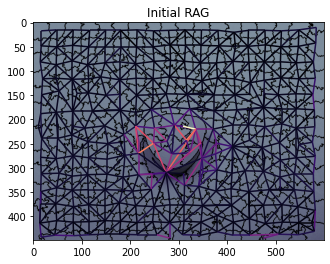

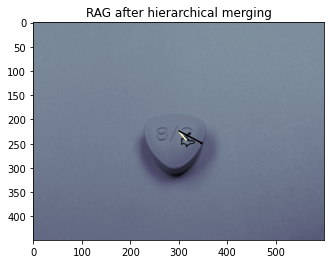

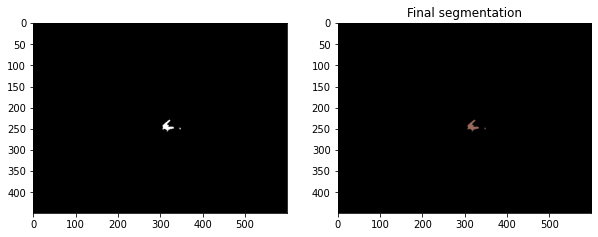

In [198]:
from functions import merge_boundary, weight_boundary, merge_mean_color, _weight_mean_color

edges = filters.sobel(cv[1])
# edges = filters.sobel(color.rgb2gray(label_rgb))
# edges = filters.sobel(color.rgb2gray(sharp))

# edges = feature.canny(color.rgb2gray(img), sigma=0.5)

def merge_hier_boundary(labels, edges, image, thresh=0.03):
    rag = graph.rag_boundary(labels, edges)
    graph.show_rag(labels, rag, image)
    plt.title('Initial RAG')

    labels = graph.merge_hierarchical(labels, rag, thresh=thresh, rag_copy=False,
                                       in_place_merge=True,
                                       merge_func=merge_boundary,
                                       weight_func=weight_boundary)
    return rag, labels

def merge_hier_color(labels, image, thresh=0.2):
    rag = graph.rag_mean_color(image, labels)
    graph.show_rag(labels, rag, image)
    plt.title('Initial RAG')
    labels = graph.merge_hierarchical(labels, rag, thresh=thresh, rag_copy=False,
                                   in_place_merge=True,
                                   merge_func=merge_mean_color,
                                   weight_func=_weight_mean_color)
    # labels2 = graph.cut_normalized(img_slic, rag, thresh=30)
    # labels2 = graph.cut_threshold(img_slic, rag, 0.2)

    return rag, labels

plt.figure()
plt.imshow(edges, cmap='gray')

rag, labels = merge_hier_boundary(img_slic, edges, image)

graph.show_rag(img_slic, rag, image)
plt.title('RAG after hierarchical merging')

out = color.label2rgb(labels, image, kind='avg', bg_label=0)
fig, ax = plt.subplots(1,2,figsize=(10,10))
ax[0].imshow(color.rgb2gray(out), cmap='gray')
ax[1].imshow(out, cmap='gray')
plt.title('Final segmentation')

plt.show()

0.5272654844739627
0.145488127809841


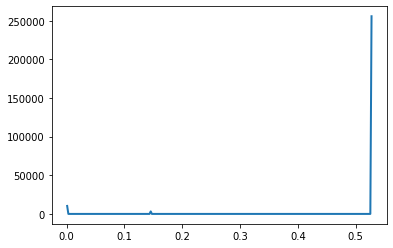

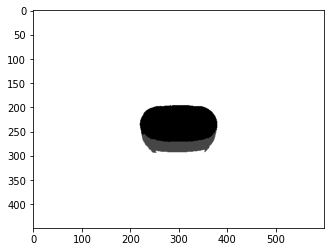

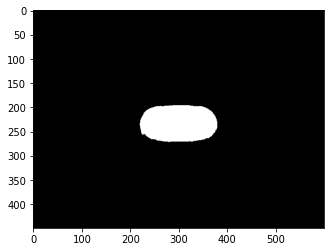

In [167]:
hist, hist_centers = exposure.histogram(color.rgb2gray(out))

plt.figure()

plt.plot(hist_centers, hist, lw=2)

print(hist_centers[np.argmax(hist)])

out1 = color.rgb2gray(out).copy()

plt.figure()
plt.imshow(out1, cmap='gray')

thresh = filters.threshold_otsu(out1)
print(thresh)

if out1[:10,:10].all() <= 0.5:
    out1 = out1 >= thresh
else:
    out1 = out1 < thresh

plt.figure()
plt.imshow(out1, cmap='gray')

1


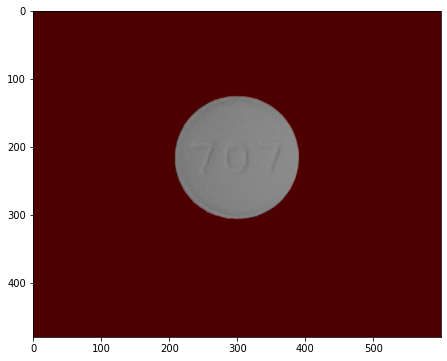

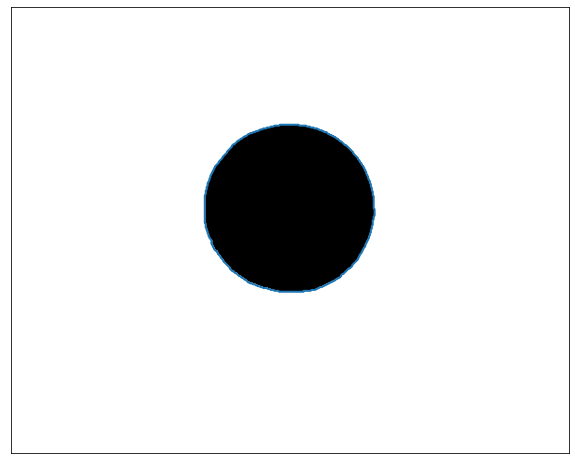

In [85]:
from skimage.color import label2rgb, rgb2gray
import matplotlib.patches as mpatches

label_image = label(out1)

# to make the background transparent, pass the value of `bg_label`,
# and leave `bg_color` as `None` and `kind` as `overlay`
image_label_overlay = label2rgb(label_image, image=image, bg_label=0)

fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(image_label_overlay)

regions = regionprops(label_image)

print(len(regions))
minr, minc, maxr, maxc = regions[0].bbox

scale = 0.02

cropped = out1[minr-int(minr*scale):maxr+int(maxr*scale), minc-int(minc*scale):maxc+int(maxc*scale)]
cropped1 = out1[minr:maxr, minc:maxc]

from skimage import measure

contours = measure.find_contours(cropped, 0.8)

if len(contours) != 0:
    # Display the image and plot all contours found
    fig, ax = plt.subplots(figsize=(10,10))
    ax.imshow(cropped, cmap=plt.cm.gray)

    for n, contour in enumerate(contours):
       # ax.plot(contour[:, 1], contour[:, 0], linewidth=2)
        pass

    contours.sort(key=len)

    ax.plot(contours[-1][:,1], contours[-1][:,0], lw=2)

    coords = contours[-1]

    ax.axis('image')
    ax.set_xticks([])
    ax.set_yticks([])
    plt.show()

In [21]:
hu_a = regions[0].moments_hu
hu_a = -1 * np.sign(hu_a) * np.log10(np.abs(hu_a))
print(hu_a)

[  0.71983549   2.53894876   7.05528952   6.3818831  -13.41547302
  -7.94731466  13.15847384]


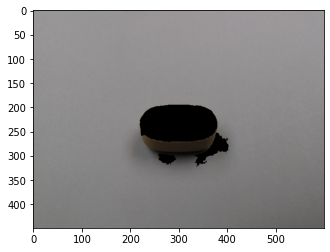

In [22]:
cropped_img = image[minr-int(minr*scale):maxr+int(maxr*scale), minc-int(minc*scale):maxc+int(maxc*scale)]
cropped_img[:,:,0] *= cropped
cropped_img[:,:,1] *= cropped
cropped_img[:,:,2] *= cropped
plt.imshow(cropped_img)

449 600 3
Fitting model on a small sub-sample of the data
Predicting color indices on the full image (k-means)
[[0.44898018 0.44102421 0.43710251]
 [0.56903286 0.5608314  0.56421371]]
[[0.44898018 0.44102421 0.43710251]
 [0.56903286 0.5608314  0.56421371]]


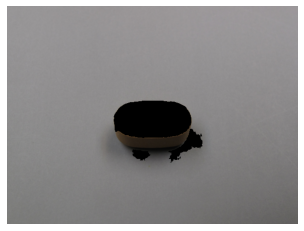

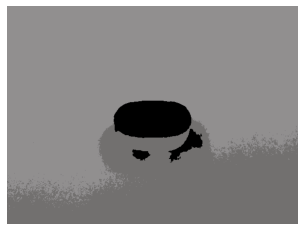

In [23]:
from sklearn.metrics import pairwise_distances_argmin
from sklearn.utils import shuffle

n_colors = 2

# Load Image and transform to a 2D numpy array.
w, h, d = cropped_img.shape
print(w,h,d)
assert d == 3

cr = np.reshape(img_as_bool(cropped), w * h)
cr_i = np.reshape(cropped_img, (w * h, d))

image_array = []

for i, p in enumerate(cr):
    if p == True:
        image_array.append(cr_i[i])

# image_array = np.reshape(cropped_img, (w * h, d))


print("Fitting model on a small sub-sample of the data")
image_array_sample = shuffle(image_array, random_state=0)[:1000]
kmeans = KMeans(n_clusters=n_colors, random_state=0).fit(image_array_sample)

# Get labels for all points
print("Predicting color indices on the full image (k-means)")
labels = kmeans.predict(image_array)

# codebook_random = shuffle(image_array, random_state=0)[:n_colors]
# print("Predicting color indices on the full image (random)")

# labels_random = pairwise_distances_argmin(codebook_random,
#                                          image_array,
#                                          axis=0)

def recreate_image(codebook, labels, w, h):
    # Recreate the (compressed) image from the code book & labels
    print(codebook)
    d = codebook.shape[1]
    image = np.zeros((w, h, d))
    label_idx = 0
    for i in range(w):
        for j in range(h):
            if cr[i * h + j] == True:
                image[i][j] = codebook[labels[label_idx]]
                label_idx += 1
    return image

# Display all results, alongside original image
plt.figure(1)
plt.clf()
plt.axis('off')
plt.imshow(cropped_img)

plt.figure(2)
plt.clf()
plt.axis('off')
image_knn = recreate_image(kmeans.cluster_centers_, labels, w, h)
plt.imshow(recreate_image(kmeans.cluster_centers_, labels, w, h))

# plt.figure(3)
# plt.clf()
# plt.axis('off')
# plt.title('Quantized image (64 colors, Random)')
# plt.imshow(recreate_image(codebook_random, labels_random, w, h))
# plt.show()

rgb [0.44898018 0.44102421 0.43710251]
hsv [0.055029   0.02645479 0.44898018]


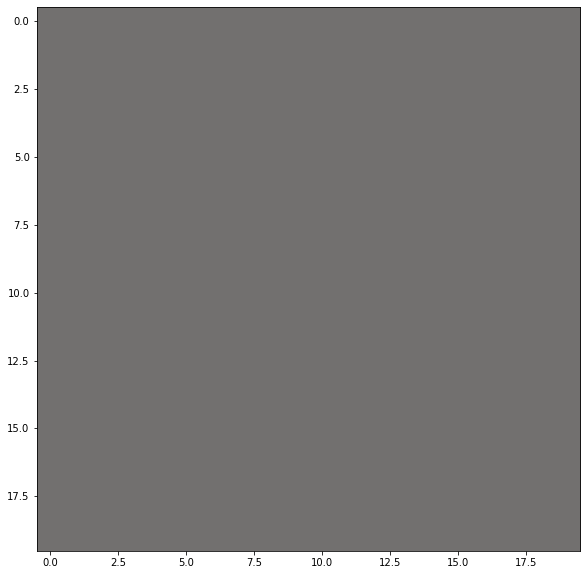

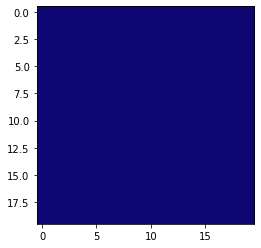

In [24]:
print('rgb', kmeans.cluster_centers_[0])

img = np.zeros([20,20,3])
img[:,:,0] = kmeans.cluster_centers_[0][0]
img[:,:,1] = kmeans.cluster_centers_[0][1]
img[:,:,2] = kmeans.cluster_centers_[0][2]

fig, ax = plt.subplots(1, 1, figsize=(10,10))
ax.imshow(img)
hsv_img = color.rgb2hsv(img)
print('hsv', hsv_img[0,0,:])

plt.figure()
plt.imshow(hsv_img, cmap='hsv')
